# Case 1

Primeiramente, vamos importar alguns pacotes importantes para a análise de dados:

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Lendo o arquivo `TFP.csv`:

In [139]:
df = pd.read_csv('TFP.csv')
df

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179
...,...,...,...
181,MEX,2007,1.013673
182,MEX,2008,0.991548
183,MEX,2009,0.915879
184,MEX,2010,0.941604


A primeira coisa que podemos fazer aqui com a base de dados é visualizar graficamente como se comporta a TFP para os três países ao longo dos anos. Para isso, vamos separar o *dataframe* original em três *dataframes* distintos: um para cada país.

In [140]:
df_USA = df[df['isocode'] == 'USA']
df_CAN = df[df['isocode'] == 'CAN']
df_MEX = df[df['isocode'] == 'MEX']

df_USA.drop('isocode', axis = 1, inplace = True)
df_CAN.drop('isocode', axis = 1, inplace = True)
df_MEX.drop('isocode', axis = 1, inplace = True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Plotando os três gráficos, teremos:

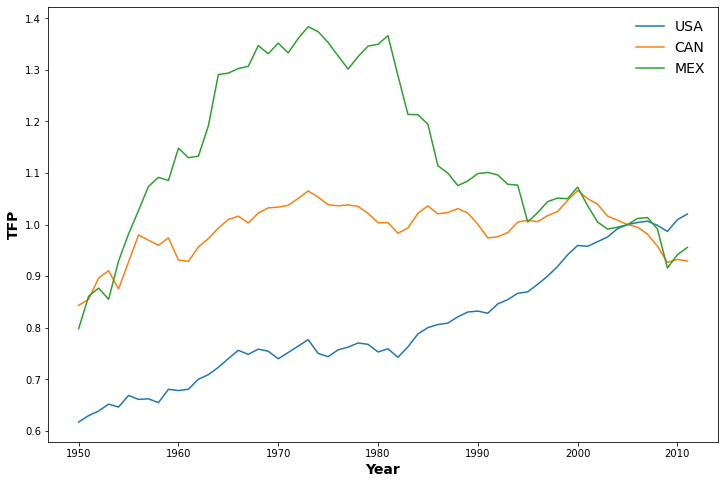

In [141]:
plt.subplots(figsize=(12,8)) #Aumentando o tamanho da figura
plt.plot(df_USA['year'], df_USA['rtfpna'], label = 'USA')
plt.plot(df_CAN['year'], df_CAN['rtfpna'], label = 'CAN')
plt.plot(df_MEX['year'], df_MEX['rtfpna'], label = 'MEX')
plt.xlabel('Year', fontweight = 'bold', fontsize = 14.0)
plt.ylabel('TFP', fontweight = 'bold', fontsize = 14.0)
plt.legend(loc='best', frameon = False, fontsize = 14.0)

## Fazendo a previsão para os próximos 10 anos

Para iniciar a análise, precisamos tomar alguns cuidados. O primeiro deles é a verificação se a série temporal é ou não **estacionária**, isto é, se propriedades estatísticas do conjunto de dados (média, desvio-padrão etc) permanecem constantes com o tempo.

Inicialmente, criei uma função que calcula a média móvel e o desvio-padrão móvel da série e aplica o teste de **Dickey-Fuller**, muito utilizado para verificar se um conjunto de dados de uma série temporal é estacionário ou não.

Farei os primeiros cálculos com os dados dos Estados Unidos e, depois de explicado o método, estenderei a análise para os outros dois países.

In [142]:
df_USA['year'] = pd.to_datetime(df_USA['year'], format = '%Y')
df_CAN['year'] = pd.to_datetime(df_CAN['year'], format = '%Y')
df_MEX['year'] = pd.to_datetime(df_MEX['year'], format = '%Y')

df_USA.set_index('year', inplace = True)
df_CAN.set_index('year', inplace = True)
df_MEX.set_index('year', inplace = True)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [143]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determinação das estatísticas móveis:
    
    rolmean = timeseries.rolling(window=5).mean()
    rolstd = timeseries.rolling(window=5).std()
    
    #Plotando:
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Média móvel')
    plt.plot(rolstd, color='black', label = 'Std móvel')
    plt.legend(loc='best')
    plt.title('Média e Desvio-padrão móveis')
    plt.show()
    
    #Dickey-Fuller test:
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

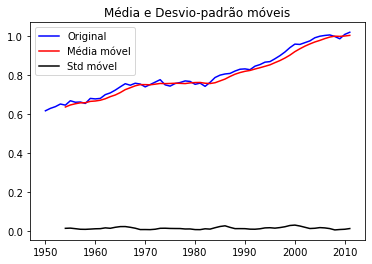

Results of Dickey-Fuller Test:
Test Statistic                  0.223647
p-value                         0.973557
#Lags Used                      0.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [144]:
test_stationarity(df_USA)

Uma vez que o teste estatístico > valor crítico (para todos os níveis de confiança), considera-se que a série temporal **não é estacionária**. Uma das razões que pode explicar a não-estacionariedade da série é justamente a média móvel que, como visto no gráfico anterior, não está constante ao longo do tempo (ou seja, há uma certa **tendência** observada)

Uma maneira de forçar os dados a serem estacionários é justamente modelar a tendência observada para posteriormente removê-la. Farei essa modelagem aplicando a função **log** nos dados da série dos USA:

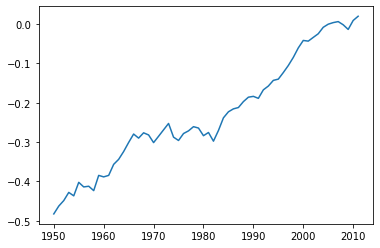

In [145]:
USA_log = np.log(df_USA)
plt.plot(USA_log)

O que vamos fazer agora é uma técnica de **suavização** dessa tendência para que ela possa ser removida do nosso dataset. Primeiro, aplicamos a média móvel nos dados anteriores:

In [146]:
USA_log_MA = USA_log.rolling(window = 5).mean()

Agora, criamos uma nova série contendo os valores resultantes da **diferença** entre o log da tendência observada (`USA_log`) e a média móvel desses valores (`USA_log_MA`):

In [147]:
USA_log_diff = USA_log - USA_log_MA
USA_log_diff.dropna(inplace=True)
USA_log_diff

,rtfpna
year,
1954-01-01,0.015052
1955-01-01,0.033352
1956-01-01,0.011924
1957-01-01,0.006391
1958-01-01,-0.005679
1959-01-01,0.022661
1960-01-01,0.016121
1961-01-01,0.014032
1962-01-01,0.030966


Aplicando novamente a função `teste_stationary`:

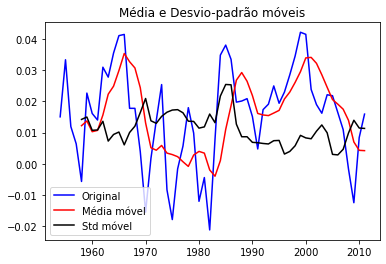

Results of Dickey-Fuller Test:
Test Statistic                 -3.906111
p-value                         0.001990
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [148]:
test_stationarity(USA_log_diff)

Pelo teste de Dickey-Fuller, afirma-se com 99% de confiança que, agora, os dados são estacionários.

Outro fator que pode causar a não-estacionariedade dos dados é a **sazonalidade**, isto é, valores muito díspares em meses/anos específicos. Para modelar esse fenômeno, usamos a técnica de **decomposição**:

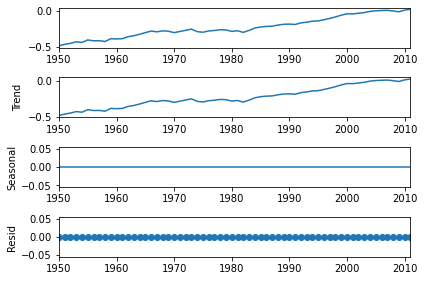

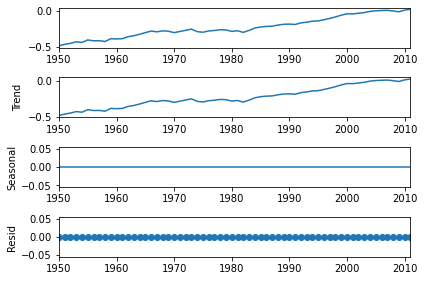

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(USA_log)
trend_USA = decomposition.trend
seasonal_USA = decomposition.seasonal
residual_USA = decomposition.resid

decomposition.plot()

Importante destacar que nossa série de dados não apresenta uma componente sazonal. Logo, podemos partir para a etapa de **predição** através do método *AutoRegressive Integrated Moving Average* **(ARIMA**). O método faz, basicamente, o seguinte:

1. Modela inicialmente através de uma relação entre um valor observado e um determinado número de observações anteriores (Auto Regression);
2. Faz o passo-a-passo anterior de diferenciação para eliminar as componentes que causam a não-estacionariedade dos dados (Integrated);
3. Modela finalmente utilizando a dependência entre um valor observado e o resíduo gerado pela média móvel aplicada à observações anteriores (Moving Average).

Cada um desses componentes é explicitado no modelo através da determinação de **parâmetros**. Como notação padrão, temos `ARIMA(p,d,q)` onde:

* p: número de observações anteriores que serão incluídas no modelo (*lag order*);
* d: número de vezes que as observações serão reduzidas (diferenciadas) para garatir estacionariedade (*grau de diferenciação*);
* q: tamanho da janela no cálculo da média móvel (*moving average order*).

Começando por chamar o modelo e o gráfico de autocorrelação do Pandas:

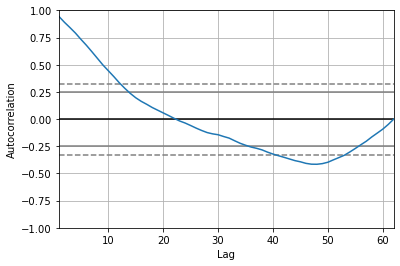

In [173]:
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_USA)

O que foi feito anteriormente foi um plot de autocorrelação para saber até que ponto ocorre uma autocorrelação positiva. Pelo gráfico, verifica-se que até um 'atraso' de 20, temos correlações positivas. Portanto, podemos supor que é significativo sempre escolher as 10 últimas observações para o primeiro modelo (AutoRegression). Como já vimos não haver influência da sazonalidade, podemos setar a diferenciação apenas para as tendências (variações na média móvel) de maneira que `d=1`. Por fim, para a média móvel, podemos escolher um valor inicial de `q=1` e avaliar a necessidade de mudança posteriormente.

In [190]:
model_USA = ARIMA(df_USA, order=(10,1,1))
model_USA_fit = model_USA.fit()
model_USA_fit.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 rtfpna   No. Observations:                   62
Model:                ARIMA(10, 1, 1)   Log Likelihood                 185.791
Date:                Fri, 18 Dec 2020   AIC                           -347.582
Time:                        17:08:09   BIC                           -322.251
Sample:                    01-01-1950   HQIC                          -337.654
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0638      8.088      0.008      0.994     -15.789      15.916
ar.L2          0.0765      0.831      0.092      0.927      -1.551       1.704
ar.L3         -0.0224      0.573     -0.039      0.969      -1.146       1.101
ar.L4          0.1895      0.261      0.725      0.469      -0.323       0.702
ar.L5          0.1168      1.599      0.073      0.942      -3.017       3.251
ar.L6          0.1283      0.936      0.137      0.891      -1.707       1.963
ar.L7          0.2082      1.053      0.198      0.843      -1.856       2.272
ar.L8          0.0575      1.668      0.034      0.973      -3.213       3.328
ar.L9         -0.1272      0.471     -0.270      0.787      -1.050       0.795
ar.L10         0.0129      1.050      0.012      0.990      -2.046       2.072
ma.L1          0.0422      8.081      0.005      0.996     -15.796      15.880
sigma2         0.0001   3.73e-05      3.485      0.000    5.69e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.85   Prob(JB):                         0.30
Heteroskedasticity (H):               0.55   Skew:                            -0.39
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

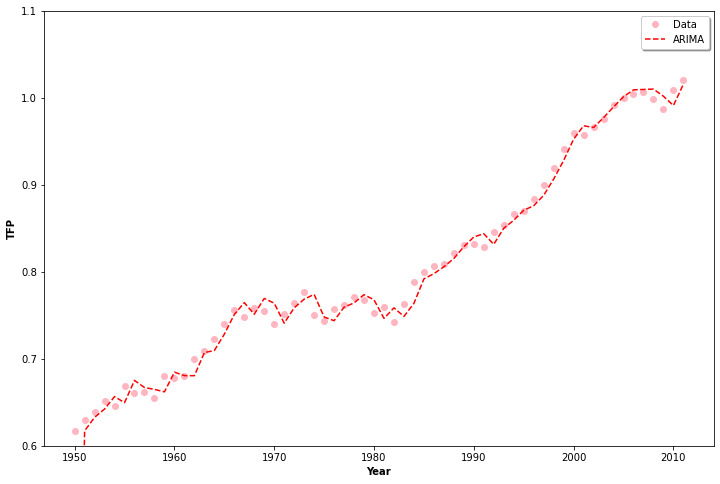

In [202]:
plt.subplots(figsize=(12,8))
plt.plot(df_USA, 'o', color = 'lightpink', label = 'Data')
plt.plot(model_USA_fit.fittedvalues, linestyle = '--', 
         color = 'red', label = 'ARIMA')
plt.xlabel('Year', fontweight = 'bold')
plt.ylabel('TFP', fontweight = 'bold')
plt.ylim([0.6,1.1])
plt.legend(loc='best', shadow = True)

O gráfico anterior mostra um ajuste perfeito entre o modelo e os dados coletados. Um outro parâmetro importante para avaliar a qualidade do modelo é a densidade de probabilidade dos resíduos:

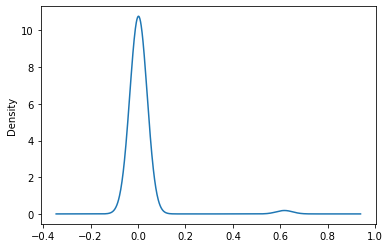

In [188]:
model_USA_fit.resid.plot(kind = 'kde')

Percebe-se com clareza que os resíduos estão concentrados em torno de 0,0, o que garante um ajuste muito satisfatório para o modelo em questão. Outro parâmetro importante no modelo é a função objetivo escolhida (no caso, a **soma do quadrado dos resíduos (RSS)**), definida como:

$ \textrm{RSS} = \sum_{i=1}^{N} (y_{pred} - y_{obs})^2 $

In [248]:
RSS_USA = np.sum(model_USA_fit.resid**2)
print('RSS = %0.4f' % RSS_USA)

RSS = 0.3889


Prevendo os próximos 10 anos:

In [250]:
USA_forecast = model_USA_fit.forecast(steps = 10)
USA_forecast

2012-01-01    1.024130
2013-01-01    1.021205
2014-01-01    1.022921
2015-01-01    1.023995
2016-01-01    1.025968
2017-01-01    1.032540
2018-01-01    1.038523
2019-01-01    1.037756
2020-01-01    1.037246
2021-01-01    1.038488
Freq: AS-JAN, Name: predicted_mean, dtype: float64

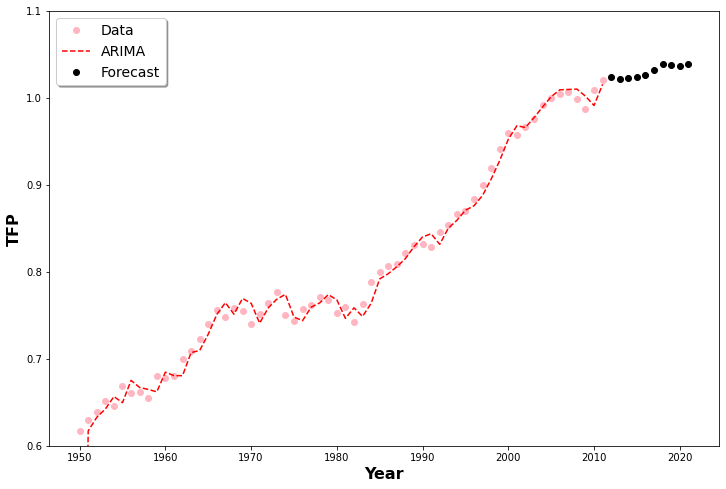

In [212]:
plt.subplots(figsize=(12,8))
plt.plot(df_USA, 'o', color = 'lightpink', label = 'Data')
plt.plot(model_USA_fit.fittedvalues, linestyle = '--', 
         color = 'red', label = 'ARIMA')
plt.plot(USA_forecast, 'o', color = 'black', label = 'Forecast')
plt.xlabel('Year', fontweight = 'bold', fontsize = 16.0)
plt.ylabel('TFP', fontweight = 'bold', fontsize = 16.0)
plt.ylim([0.6,1.1])
plt.legend(loc='upper left', shadow = True, fontsize = 14.0)

### Análise para o CAN

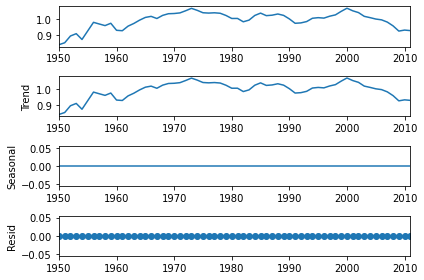

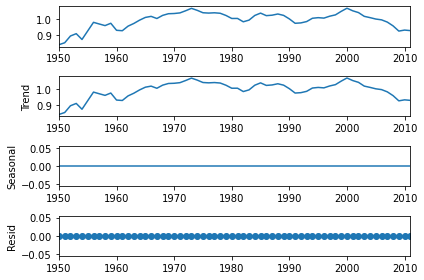

In [222]:
decomposition_CAN = seasonal_decompose(df_CAN)
trend_CAN = decomposition_CAN.trend
seasonal_CAN = decomposition_CAN.seasonal
residual_CAN = decomposition_CAN.resid

decomposition_CAN.plot()

**Conclusão**: único fator que contribui para a não-estacionariedade é a *trend*. Portanto, setamos `d=1`

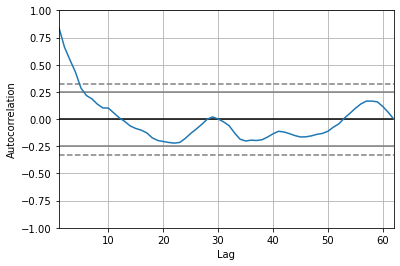

In [252]:
autocorrelation_plot(df_CAN)

**Conclusão**: escolha do parâmetro p = 5.

In [253]:
model_CAN = ARIMA(df_CAN, order=(5,1,1))
model_CAN_fit = model_CAN.fit()
model_CAN_fit.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 rtfpna   No. Observations:                   62
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 161.734
Date:                Fri, 18 Dec 2020   AIC                           -309.468
Time:                        18:11:13   BIC                           -294.692
Sample:                    01-01-1950   HQIC                          -303.677
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2283      0.476     -0.480      0.631      -1.161       0.704
ar.L2         -0.0739      0.230     -0.322      0.748      -0.524       0.376
ar.L3          0.0740      0.229      0.324      0.746      -0.374       0.522
ar.L4          0.1542      0.182      0.845      0.398      -0.203       0.512
ar.L5         -0.2249      0.118     -1.904      0.057      -0.456       0.007
ma.L1          0.5934      0.500      1.187      0.235      -0.387       1.574
sigma2         0.0003   6.48e-05      4.441      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.30
Prob(Q):                              0.82   Prob(JB):                         0.32
Heteroskedasticity (H):               0.46   Skew:                             0.37
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Comparando visualmente os dados e o modelo:

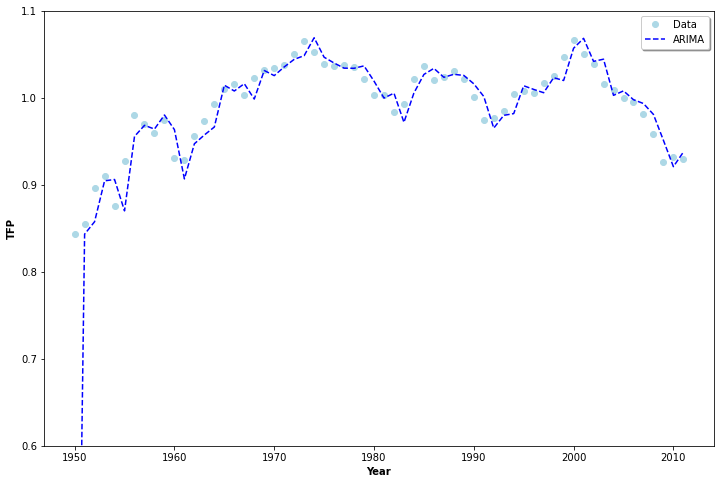

In [254]:
plt.subplots(figsize=(12,8))
plt.plot(df_CAN, 'o', color = 'lightblue', label = 'Data')
plt.plot(model_CAN_fit.fittedvalues, linestyle = '--', 
         color = 'blue', label = 'ARIMA')
plt.xlabel('Year', fontweight = 'bold')
plt.ylabel('TFP', fontweight = 'bold')
plt.ylim([0.6,1.1])
plt.legend(loc='best', shadow = True)

E os resíduos...

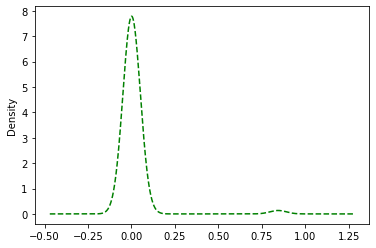

In [226]:
model_CAN_fit.resid.plot(kind = 'kde', linestyle = '--', color = 'green')

RSS:

In [249]:
RSS_CAN = np.sum(model_CAN_fit.resid**2)
print('RSS = %0.4f' % RSS_CAN)

RSS = 0.7293


Prevendo os próximos 10 anos...

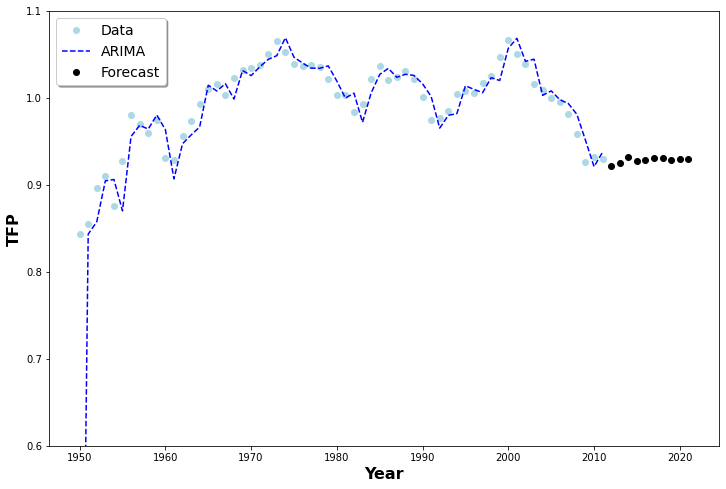

In [227]:
CAN_forecast = model_CAN_fit.forecast(steps = 10)

plt.subplots(figsize=(12,8))
plt.plot(df_CAN, 'o', color = 'lightblue', label = 'Data')
plt.plot(model_CAN_fit.fittedvalues, linestyle = '--', 
         color = 'blue', label = 'ARIMA')
plt.plot(CAN_forecast, 'o', color = 'black', label = 'Forecast')
plt.xlabel('Year', fontweight = 'bold', fontsize = 16.0)
plt.ylabel('TFP', fontweight = 'bold', fontsize = 16.0)
plt.ylim([0.6,1.1])
plt.legend(loc='upper left', shadow = True, fontsize = 14.0)

### E para o MEX

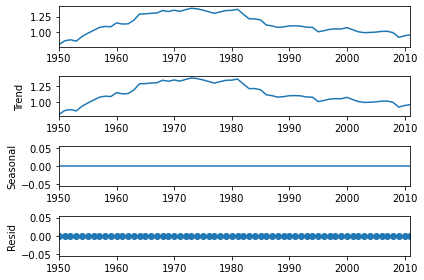

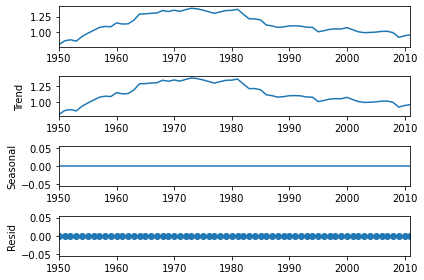

In [228]:
decomposition_MEX = seasonal_decompose(df_MEX)
trend_MEX = decomposition_MEX.trend
seasonal_MEX = decomposition_MEX.seasonal
residual_MEX = decomposition_MEX.resid

decomposition_MEX.plot()

**Conclusão**: único fator que contribui para a não-estacionariedade é a *trend*. Portanto, setamos `d=1`

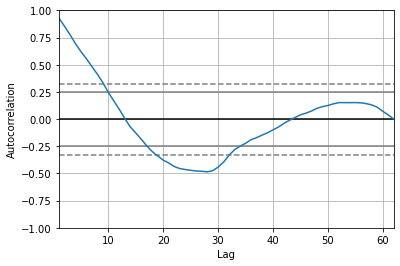

In [229]:
autocorrelation_plot(df_MEX)

**Conclusão**: escolha do parâmetro `p = 5`.

In [230]:
model_MEX = ARIMA(df_MEX, order=(5,1,1))
model_MEX_fit = model_MEX.fit()
model_MEX_fit.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 rtfpna   No. Observations:                   62
Model:                 ARIMA(5, 1, 1)   Log Likelihood                 121.836
Date:                Fri, 18 Dec 2020   AIC                           -229.672
Time:                        17:37:23   BIC                           -214.896
Sample:                    01-01-1950   HQIC                          -223.881
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3823      0.384     -0.996      0.319      -1.135       0.370
ar.L2          0.1439      0.210      0.685      0.493      -0.268       0.556
ar.L3          0.1096      0.183      0.597      0.550      -0.250       0.469
ar.L4          0.2837      0.149      1.909      0.056      -0.008       0.575
ar.L5         -0.0978      0.269     -0.363      0.717      -0.626       0.430
ma.L1          0.7071      0.365      1.940      0.052      -0.007       1.422
sigma2         0.0011      0.000      5.657      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.91
Prob(Q):                              0.94   Prob(JB):                         0.38
Heteroskedasticity (H):               0.77   Skew:                            -0.37
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

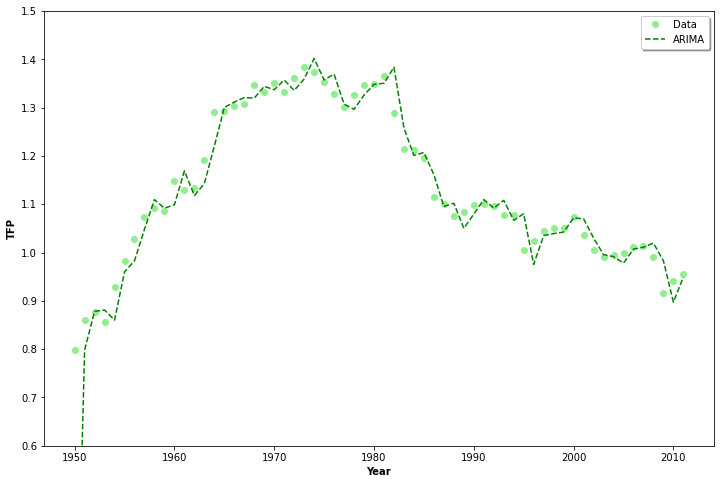

In [232]:
plt.subplots(figsize=(12,8))
plt.plot(df_MEX, 'o', color = 'lightgreen', label = 'Data')
plt.plot(model_MEX_fit.fittedvalues, linestyle = '--', 
         color = 'green', label = 'ARIMA')
plt.xlabel('Year', fontweight = 'bold')
plt.ylabel('TFP', fontweight = 'bold')
plt.ylim([0.6,1.5])
plt.legend(loc='best', shadow = True)

Bom ajuste do modelo aos dados da série temporal. E os resíduos?

In [255]:
RSS_MEX = np.sum(model_MEX_fit.resid**2)
print('RSS = %0.4f' % RSS_MEX)

RSS = 0.7034


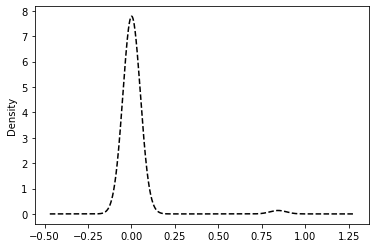

In [233]:
model_CAN_fit.resid.plot(kind = 'kde', linestyle = '--', color = 'black')

Resíduos próximos de zero, modelo prevê bem os dados. E para os próximos 10 anos?

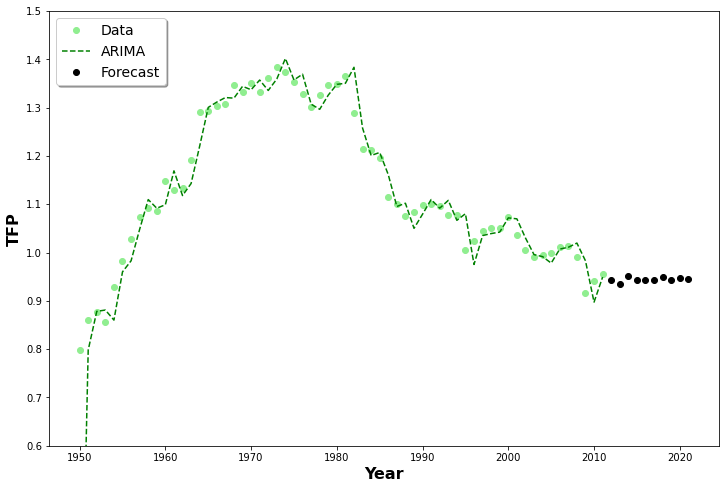

In [235]:
MEX_forecast = model_MEX_fit.forecast(steps = 10)

plt.subplots(figsize=(12,8))
plt.plot(df_MEX, 'o', color = 'lightgreen', label = 'Data')
plt.plot(model_MEX_fit.fittedvalues, linestyle = '--', 
         color = 'green', label = 'ARIMA')
plt.plot(MEX_forecast, 'o', color = 'black', label = 'Forecast')
plt.xlabel('Year', fontweight = 'bold', fontsize = 16.0)
plt.ylabel('TFP', fontweight = 'bold', fontsize = 16.0)
plt.ylim([0.6,1.5])
plt.legend(loc='upper left', shadow = True, fontsize = 14.0)

## Pergunta final:

Check in the following link pages 2 and 3: https://cran.r-project.org/web/packages/pwt8/pwt8.pdf to see a list of all variables in the original dataset. Can you think about another feature that could be helpful in explaining TFP series? Explain.

### Resposta:



O pacote `pwt8` contém um dataset com diversas colunas informando, resumidamente, níveis de renda, produção, insumos e produtividade para 167 países entre 1950 e 2011 (ano base: 2005).

É sabido que o TFP é definida como a parcela do crescimento do produto que não é explicada pelo crescimento dos insumos. Além disso, o capital humano agregado tem um efeito significativo no crescimento econômico, de magnitude não inferior ao efeito microeconômico da educação sobre os salários [[1]](https://www.scielo.br/scielo.php?script=sci_arttext&pid=S0034-71402010000200002). Logo, é de se esperar que a coluna `hc`, que representa o índice de capital humano por pessoa, baseado em anos de escolaridade, tenha efeito significativo nas tendências observadas no *dataset* fornecido. Se pegarmos os dados do México, por exemplo, que experimenta um vertiginoso crescimento da TFP a partir dos anos 1960, é possível perceber que este crescimento coincide com política governamental da época de investimento maciço na indústria manufatureira, que atraiu o investimento estrangeiro. A Revolução Verde também contribuiu para o aumento exponencial das exportações de grãos no México, tornando-o autossuficiente na produção de alimentos. 

Segundo Solow[[2]](http://www.dartmouth.edu/~dcomin/files/def.pdf), se a função de produção for neoclássica, se existe competição perfeita entre os fatores de mercado e as taxas de crescimento das entradas forem medidas precisamente, então os resíduos definidos por Solow são uma boa estimativa da TFP. Nesse sentido, a divisão de capitais exerce um papel fundamental nessa estimativa, o que nos leva a inferir que as colunas `csh_c`, `csh_i`, `csh_g`, `csh_x`, `csh_m` e `csh_r` também são importantes para explicar as tendências observadas.